# Classification using logistic regression
For this exercise we'll be using [scikit-learn](https://scikit-learn.org/stable/). This is great library/module for predictive data analysis in Python. It's got a huge library of algorithms and models, from standard linear models like regression, to Support Vector Machines, Decision Trees, and Neural Networks. We'll start with logistic regression.

## Normalization of image data
When working with images in machine learning, it's common to apply some kind of normalization to the pixel values.
One of the common ways to normalize image data is to scale the values to the [0, 1] interval. This is what we will do here,
using min-max scaling.
Min-max scaling preserves the shape of the distribution, so that the difference between each image in
a set of images is also preserved. In doing so, we are assuming that this property in the data is important,
but keep in mind that it is something we can change, should we want to.
Min-max scaling is calculated as
$$\text{scaled image} = \frac{\text{image} - \mu_{image}}{I_{max} - I_{min}},$$
where $I_{max}$ and $I_{min}$ refer to the maximum and minimum pixel intensity,
and $\mu_{image}$ is the mean pixel intensity for the set of images.

We'll implement this as a function `normalize_image_data()`.
However, we're not going to use it quite yet. We won't apply normalization to the data before we've split it into
a training set and a validation set. If we normalize the entire dataset, then split it, we've techinically
included properties of the validation set in the training set. This can give you a false picture of how well
your model is performing, and should be avoided.

Note that sklearn has a function for this too, an entire library for data preprocessing, actually.
Check it out [here](https://scikit-learn.org/stable/modules/preprocessing.html).\
We're also going to save this normalization function to a separate python file called `helper_functions.py`.
That way, we don't need to define it in every single notebook we make. We can just import it from that file.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# Define the normalization function
def normalize_image_data(images):
    """ Takes an imported set of images and normalizes values to between
    0 and 1 using min-max scaling across the whole image set.
    """
    img_term = np.amax(images) - np.amin(images)
    img_mean = np.mean(images)
    images = (images - img_mean) / img_term
    return images

In [3]:
# Load images and labels.
DATA_PATH = "../data/"

images = np.load(DATA_PATH+"images_training.npy")
labels = np.load(DATA_PATH+"labels_training.npy")

# Split the training indices into training and validation. 
# Validate with 25% of the data (default). Can be adjusted.
x_idx = np.arange(images.shape[0])
train_idx, val_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.25)

### Fit to the training data
The documentation for the LogistigRegression class is available [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression).

We'll start off with the default settings for the algorithm, and once we've got everything working we'll take a look
at tuning the *hyperparameters*.

Recall the shape of the images we stored in the data_import_exploration notebook. It's (n_images, 16, 16), but the regression
class expect a vector, so to input them we need to reshape the array again.

In [4]:
images = images.reshape(images.shape[0], 256)

In [5]:
# Init logreg class and fit to the training data.
logreg = LogisticRegression()

# We pass normalized image data to the function.
logreg.fit(normalize_image_data(images[train_idx]), labels[train_idx])

LogisticRegression()

# Evaluate the model
To go further into the backround for the chosen metrics, we need to establish four quantities that appear in
most, if not all discussion of the topic. These are:
* True positive (TP) - Double event classified as double event
* True negative (TN) - Single event classified as single event
* False positive (FP) - Single event classified as double event
* False negative (FN) - Double event classified as single event

Which type of event is "positive" and "negative" is an arbitrary choice. We have chosen to label our events
such that 0 = single and 1 = double. Those of Scikit-Learn's metrics which use the class labels treat
the class labeled as $1$ as the positive class, which we'll see later.

From these terms we can define some properties of a classifier:\
**Sensitivity** (or **True positive rate** (TPR), or **recall**) measures the fraction of positive samples in the data
that are correctly classified as positive.

$$\text{sensitivity} = \frac{\text{number of true positives}}{\text{number of true positives} + \text{number of false negatives}} = \frac{TP}{TP + FN}$$

**Specificity** (or **True negative rate** (TNR)) measures the fraction of negative samples in the data that are correctly classified as negative.

$$\text{specificity} = \frac{\text{number of true negatives}}{\text{number of true negatives} + \text{number of false positives}} = \frac{TN}{TN + FP}$$

**Precision** (or **Positive preditive value** (PPV)) measures the fraction of samples classified as positive
that are correctly classified.

$$\text{precision} = \frac{\text{number of true positives}}{\text{number of true positives} + \text{number of false positives}} = \frac{TP}{TP + FP}$$
## Accuracy
The accuracy is a well known measure of performance, but not always a good one. It's simply the fraction of
all samples that were correctly classified. Or, using the terms above
$$\text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

This is the default score for the LogisticRegression class in scikit-learn, but is also available as a standalone
function in Scikit-Learn's metrics as [accuracy_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score).

In [10]:
from sklearn.metrics import accuracy_score
# Make a set of predictions to evaluate
pred = logreg.predict(normalize_image_data(images[val_idx]))

# Convert sigmoid values from classification to integers so it works with the metric functions.
result = pred > 0.5
acc = accuracy_score(labels[val_idx], result)
print("Accuracy:", acc)

Accuracy: 0.7302222222222222


Why is it not always a good performance metric?

Suppose you have a classifier which predicts every sample to be a double event. If you apply this classifier to
a set of events that is not balanced you will get a false picture of its performance.

Example:\
For a set of 15 single events and 85 double events, the accuracy of this particular classifier would be 85%!
But it's clearly a terrible classifier.

So what can we do instead?

## Confusion Matrix
The confusion matrix can be a useful metric to gain a little bit
more insight into specifically what the model gets wrong (or right).

The confusion matrix is an n by n matrix containing correct classifications (true)
on the diagonal, and false positives and negatives in the off-diagonal elements.
An example of such a matrix could be the following table:

|                  | True Single | True Double |
|:-----------------|:-----------:|:-----------:|
| **Classified Single** | 5 (TN) | 1 (FN)      |
| **Classified Double** | 3 (FP) | 6 (TP)      |

In the table above, the diagonal elements $i = j$ are the correct classifications, 
while the other elements correspond to cases where the model predicted class 
$i$, but should've predicted class $j$. The confusion matrix thus gives information about 
false positives and false negatives, in addition to classification accuracy. 
This is very useful in cases where for example false positives can be readily ignored or 
filtered later, but false negatives may have severe consequences. An example of this
could be detection of cancer, in which a false positive can be ruled out from further testing, 
while a false negative may lead to a patient being sent home when actually needing help.

We can compute the confusion matrix using Scikit-Learn's [confusion matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [7]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels[val_idx], result)

array([[822, 293],
       [314, 821]])

## F1 score
The F1 score is a also a measure of accuracy of the model, but it accounts for more than regular accuracy.
It is defined as

$$F_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}},$$

which is the harmonic mean of precision and recall. Why is this better than accuracy? By including both precision and
recall, you are combining two metrics that both tell you something about how good the model is at classifying your "positive" class. For our case of single and double events, the default behaviour of scikit-learn's f1_score function tells us about
how good the model is at classifying double events. We can also specify single events as the "positive" class to get some
insight into that aswell. Scikit-Learn provides this metric through [f1_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

In [9]:
from sklearn.metrics import f1_score
score_double = f1_score(labels[val_idx], result)
print("F1-score, double as positive class: ", score_double)

score_single = f1_score(labels[val_idx], result, pos_label=0)
print("F1-score, single as positive class: ", score_single)

F1-score, double as positive class:  0.7301022676745221
F1-score, single as positive class:  0.7303420701910261


Since the F1 score doesn't take into account the true negatives that can be seen in the confusion matrix, it has met
some critisism, especially for use in binary classification.
A common metric that is recommended to use instead, is Matthews Correlation Coefficient.

## Matthews correlation coefficient (MCC)
MCC is tailored to measure the quality of a binary classifier, and is popular in bioinformatics. It accounts for both
true and false positives and negatives, leading to a good overall metric if you have to boil the performance down
to a single number. Additionally, the MCC is invariant to which class is defined as the positive one.
It ranges between -1 and +1, where +1 indicates a perfect classifier, 0 is equivalent to random guessing, and -1
is a classifier which classifies every sample wrong. -1 is essentially a perfect classifier that has been "flipped"
(as long as it's a binary classifier).

MCC is defined as
$$\text{MCC} = \frac{ TP \cdot TN - FP \cdot FN } {\sqrt{ (TP + FP) ( TP + FN ) ( TN + FP ) ( TN + FN ) } },$$

where the quantities are the same as those defined for the confusion matrix above.

Scikit-Learn's metrics implement this as [matthews_corrcoef()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)

In [12]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(labels[val_idx], result)
print("MCC:", mcc)

MCC: 0.460571569918845


## ROC-curve and Area Under Curve
The Receiver Operating Characteristic (ROC) is a widely used measure of a
classifiers performance . The performance is measured as the effect
of the true positive rate (TPR) and the false positive rate (FPR) as a function
of thresholding the positive class. To evaluate the ROC curve for a model,
traditionally the Area Under the Curve (AUC) is used, which ranges from 0
(an ideal "opposite" classifier) to 1.0 (an ideal classifier) with 0.5
indicating a random choice classifier.

Scikit-Learn includes these metrics as [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html?highlight=roc_curve) and [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). They also have an article on [ROC](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) with plot examples.

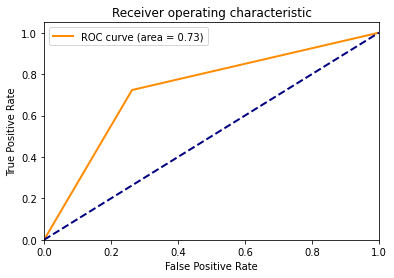

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(labels[val_idx], pred)
roc_auc = roc_auc_score(labels[val_idx], pred)
# Plot the curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label="ROC curve (area = {:0.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend()
plt.show()